In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np 

def average_time_between_events(event_vector, time_per_sample):
    """
    Calculates the average duration of non-event periods (0s) that occur
    strictly between event periods (1s).

    Args:
        event_vector (list or numpy array): A sequence of 0s and 1s.
        time_per_sample (float): The duration (e.g., in seconds) represented
                                 by each element in the vector.

    Returns:
        float: The average duration (in the units of time_per_sample)
               between event occurrences. Returns numpy.nan if there are
               fewer than two distinct event periods (i.e., no gaps *between* events).
    """
    if not isinstance(event_vector, (list, np.ndarray)):
        raise TypeError("event_vector must be a list or numpy array")
    if time_per_sample <= 0:
        raise ValueError("time_per_sample must be positive")

    # Group consecutive identical values and get their type (0 or 1) and count
    # Example: [0,0,1,1,0,1] -> [(0, 2), (1, 2), (0, 1), (1, 1)]
    groups = [(key, len(list(group))) for key, group in itertools.groupby(event_vector)]

    gap_lengths = []
    # Iterate through the groups to find sequences of 0s between sequences of 1s
    # We need at least 3 groups (1, 0, 1) to have a gap *between* events
    if len(groups) >= 3:
        for i in range(1, len(groups) - 1):
            prev_key, _ = groups[i-1]
            current_key, current_length = groups[i]
            next_key, _ = groups[i+1]

            # Check if the current group is 0s and surrounded by 1s
            if prev_key == 1 and current_key == 0 and next_key == 1:
                gap_lengths.append(current_length)

    # Calculate durations and the average
    if not gap_lengths:
        # No gaps found between laughter events
        print("No gaps found between laughter events.")
        return np.nan
    else:
        gap_durations = [length * time_per_sample for length in gap_lengths]
        average_duration = np.mean(gap_durations)
        #print(f"Found {len(gap_durations)} gap(s) between laughter events.")
        #print(f"Gap lengths (in samples): {gap_lengths}")
        #print(f"Gap durations (in seconds): {[round(d, 2) for d in gap_durations]}")
        return average_duration, gap_durations

In [2]:
file_path = '/Volumes/T7 Shield/friends/stimuli/s2/'
myFiles = [f for f in os.listdir(file_path) if f.endswith(".csv")]
myFiles

['friends_s02e01a_laughter_1.49sec.csv',
 'friends_s02e01b_laughter_1.49sec.csv',
 'friends_s02e02a_laughter_1.49sec.csv',
 'friends_s02e02b_laughter_1.49sec.csv',
 'friends_s02e03a_laughter_1.49sec.csv',
 'friends_s02e03b_laughter_1.49sec.csv',
 'friends_s02e04a_laughter_1.49sec.csv',
 'friends_s02e04b_laughter_1.49sec.csv',
 'friends_s02e05a_laughter_1.49sec.csv',
 'friends_s02e05b_laughter_1.49sec.csv',
 'friends_s02e06a_laughter_1.49sec.csv',
 'friends_s02e06b_laughter_1.49sec.csv',
 'friends_s02e07a_laughter_1.49sec.csv',
 'friends_s02e07b_laughter_1.49sec.csv',
 'friends_s02e08a_laughter_1.49sec.csv',
 'friends_s02e08b_laughter_1.49sec.csv',
 'friends_s02e09a_laughter_1.49sec.csv',
 'friends_s02e09b_laughter_1.49sec.csv',
 'friends_s02e10a_laughter_1.49sec.csv',
 'friends_s02e10b_laughter_1.49sec.csv',
 'friends_s02e11a_laughter_1.49sec.csv',
 '._friends_s02e11a_laughter_1.49sec.csv',
 'friends_s02e11b_laughter_1.49sec.csv',
 'friends_s02e12a_laughter_1.49sec.csv',
 'friends_s02e

In [3]:
gap_durations_all = []
for curr_file in myFiles:
    print(curr_file)
    df = pd.read_csv(file_path + curr_file)
    sampling_interval = 1.49 
    avg_gap, gap_durations          = average_time_between_events(df['ls_binary'].values, sampling_interval)
    gap_durations_all.append(np.asarray(gap_durations))
    print(f"\nAverage duration between laughter events: {avg_gap:.2f} seconds")


friends_s02e01a_laughter_1.49sec.csv

Average duration between laughter events: 12.89 seconds
friends_s02e01b_laughter_1.49sec.csv

Average duration between laughter events: 12.66 seconds
friends_s02e02a_laughter_1.49sec.csv

Average duration between laughter events: 13.66 seconds
friends_s02e02b_laughter_1.49sec.csv

Average duration between laughter events: 15.05 seconds
friends_s02e03a_laughter_1.49sec.csv

Average duration between laughter events: 16.18 seconds
friends_s02e03b_laughter_1.49sec.csv

Average duration between laughter events: 18.60 seconds
friends_s02e04a_laughter_1.49sec.csv

Average duration between laughter events: 16.31 seconds
friends_s02e04b_laughter_1.49sec.csv

Average duration between laughter events: 19.42 seconds
friends_s02e05a_laughter_1.49sec.csv

Average duration between laughter events: 16.81 seconds
friends_s02e05b_laughter_1.49sec.csv

Average duration between laughter events: 16.09 seconds
friends_s02e06a_laughter_1.49sec.csv

Average duration betwe

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte

In [4]:
flattened_array = np.concatenate(gap_durations_all)
flattened_array.shape

(736,)

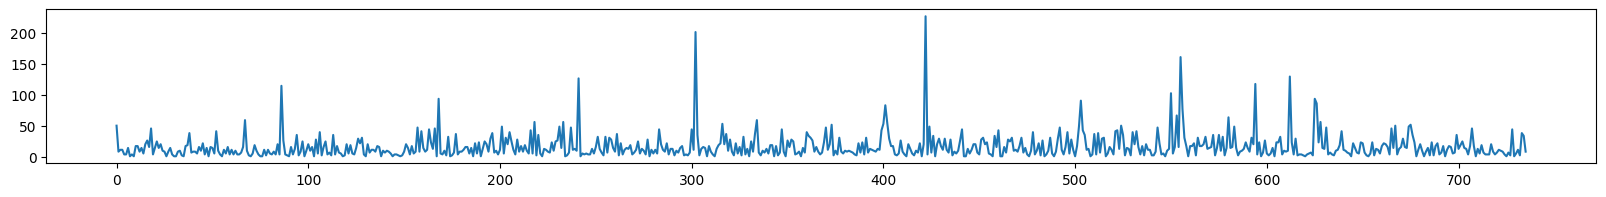

In [5]:
plt.figure(figsize = (20,2))
plt.plot(flattened_array)

(array([586., 109.,  27.,   4.,   3.,   4.,   0.,   1.,   1.,   1.]),
 array([  1.49 ,  23.989,  46.488,  68.987,  91.486, 113.985, 136.484,
        158.983, 181.482, 203.981, 226.48 ]),
 <BarContainer object of 10 artists>)

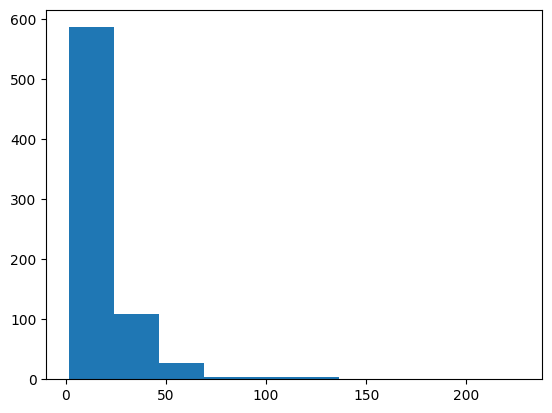

In [8]:
plt.hist(flattened_array)

In [6]:
np.mean(flattened_array)

17.12690217391304

In [7]:
np.mean(flattened_array)

17.12690217391304

In [55]:
26*60


1560

In [56]:
1560/13.63


114.45341159207629